# Predicting Probability of Quitting and Providing Prevention Hints

## 1. Import Necessary Libraries

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import json

## 2. Load the Dataset and Check Duplicates

In [19]:
# Load the dataset
file_path = 'D:\\Python_Projects\\attrition_predictor\\data\\HR_Dataset.csv'
df = pd.read_csv(file_path)

# Select only the relevant columns
selected_columns = ['satisfaction_level', 'time_spend_company', 'average_montly_hours', 'number_project', 'salary', 'left']
df = df[selected_columns]

# Identify all duplicates, including their first occurrences
all_duplicates = df.duplicated(keep=False)

# Filter the DataFrame to show only duplicate rows
duplicate_rows_df = df[all_duplicates]

# Check if there are any duplicates
if not duplicate_rows_df.empty:
    # Sort the DataFrame by all columns to help in visually comparing the duplicate entries
    sorted_duplicate_rows_df = duplicate_rows_df.sort_values(by=list(df.columns))

    # Display the number of additional copies only
    # We use df.duplicated() without keep=False to count only the additional copies
    additional_copies_count = df.duplicated().sum()
    print(f'Number of additional duplicate copies (excluding the first occurrence): {additional_copies_count}')
    print('Duplicate Rows (including originals):')
    print(sorted_duplicate_rows_df)

    # Save to a CSV file if it doesn't exist
    csv_file_path = 'duplicate_rows.csv'
    if not os.path.exists(csv_file_path):
        sorted_duplicate_rows_df.to_csv(csv_file_path, index=False)
        print(f'All duplicate rows (including originals) have been saved to "{csv_file_path}".')
    else:
        print(f'The file "{csv_file_path}" already exists.')

    # Remove all duplicate rows, keeping only the first occurrence
    df = df.drop_duplicates()

    # Confirm the removal
    print(f'Number of rows after removing duplicates: {df.shape[0]}')
else:
    print('No duplicate rows found.')


Number of additional duplicate copies (excluding the first occurrence): 3646
Duplicate Rows (including originals):
       satisfaction_level  time_spend_company  average_montly_hours  \
765                  0.09                   2                   214   
12765                0.09                   2                   214   
990                  0.09                   4                   244   
1053                 0.09                   4                   244   
1211                 0.09                   4                   244   
...                   ...                 ...                   ...   
12916                1.00                   4                   245   
10900                1.00                   5                   171   
13111                1.00                   5                   171   
11206                1.00                   7                   194   
13417                1.00                   7                   194   

       number_project  salary  l

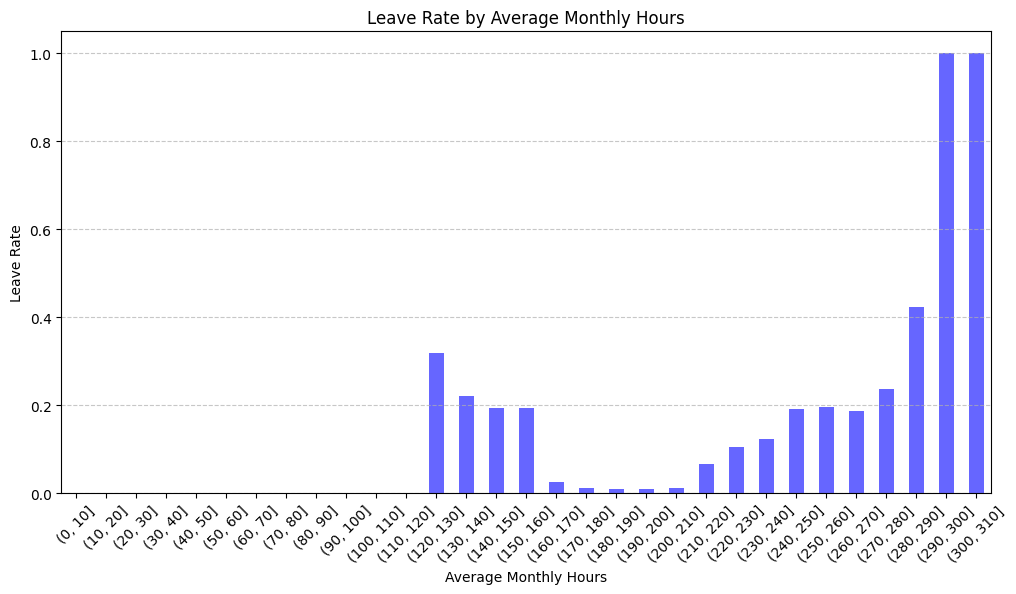

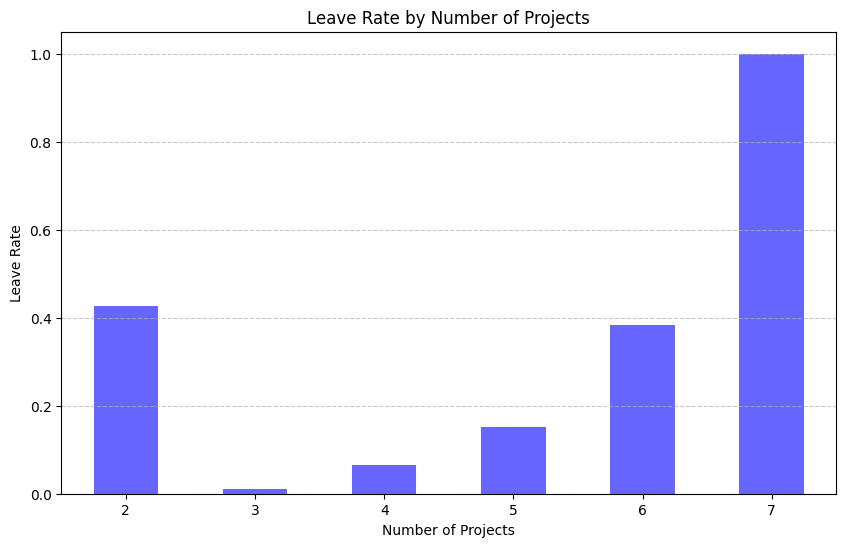

In [20]:
# Plot the leave rate by average monthly hours
def plot_left_rate_by_hours(df, bin_width=10):
    bins = range(0, df['average_montly_hours'].max() + bin_width, bin_width)
    df['hours_bin'] = pd.cut(df['average_montly_hours'], bins=bins)
    grouped = df.groupby('hours_bin')['left'].mean()
    count = df.groupby('hours_bin')['left'].count()

    plt.figure(figsize=(12, 6))
    grouped.plot(kind='bar', color='blue', alpha=0.6)
    plt.xlabel('Average Monthly Hours')
    plt.ylabel('Leave Rate')
    plt.title('Leave Rate by Average Monthly Hours')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot leave rate by average monthly hours
plot_left_rate_by_hours(df)

# Plot leave rate by number of projects
def plot_left_rate_by_projects(df):
    grouped = df.groupby('number_project')['left'].mean()
    count = df.groupby('number_project')['left'].count()

    plt.figure(figsize=(10, 6))
    grouped.plot(kind='bar', color='blue', alpha=0.6)
    plt.xlabel('Number of Projects')
    plt.ylabel('Leave Rate')
    plt.title('Leave Rate by Number of Projects')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot leave rate by number of projects
plot_left_rate_by_projects(df)

## 3. Data Preprocessing

In [21]:
# Identify numerical and categorical columns
numerical_cols = ['satisfaction_level', 'time_spend_company', 'average_montly_hours', 'number_project']
ordinal_cols = ['salary']

# Define the ordinal encoder for the 'salary' column
salary_categories = ['low', 'medium', 'high']
ordinal_encoder = OrdinalEncoder(categories=[salary_categories])

# Preprocessing pipeline for classification
preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('ord', ordinal_encoder, ordinal_cols)
    ]
)

# Preprocessing pipeline for regression
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['average_montly_hours', 'time_spend_company', 'number_project']),
        ('ord', ordinal_encoder, ordinal_cols)
        # Check if there's a 'nom' transformer and add it if missing
    ]
)

# Define the feature columns and the target column for classification
X_class = df.drop(columns=['left'])
y_class = df['left']

# Define the feature columns and the target column for regression
X_reg = df.drop(columns=['satisfaction_level', 'left'])
y_reg = df['satisfaction_level']

# Split data into training and test sets for classification
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

# Split data into training and test sets for regression
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

## 4. Resampling Techniques for Classification

In [22]:
# Function to resample data using different techniques
def resample_data(X, y, sampler):
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"Resampled dataset shape: {Counter(y_resampled)}")
    return X_resampled, y_resampled

# Apply resampling techniques
samplers = {
    'Random OverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'Borderline SMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

X_class_train_transformed = preprocessor_class.fit_transform(X_class_train)

resampled_datasets = {}
for name, sampler in samplers.items():
    print(f'Applying {name}...')
    X_resampled, y_resampled = resample_data(X_class_train_transformed, y_class_train, sampler)
    resampled_datasets[name] = (X_resampled, y_resampled)
    print('-' * 40)

# Also include the original dataset
resampled_datasets['Original'] = (X_class_train_transformed, y_class_train)

Applying Random OverSampler...
Resampled dataset shape: Counter({1: 6869, 0: 6869})
----------------------------------------
Applying SMOTE...
Resampled dataset shape: Counter({1: 6869, 0: 6869})
----------------------------------------
Applying Borderline SMOTE...
Resampled dataset shape: Counter({1: 6869, 0: 6869})
----------------------------------------
Applying ADASYN...
Resampled dataset shape: Counter({1: 6902, 0: 6869})
----------------------------------------


## 5. Hyperparameter Tuning and Evaluation Functions

In [23]:

# Hyperparameter grids
param_grids_classification = {
    'Logistic Regression': {'model__C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15]},
    'XGBoost': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7]},
    'Gradient Boosting': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5]},
    'K-Nearest Neighbors': {'model__n_neighbors': [3, 5, 7]}
}

param_grids_regression = {
    'Linear Regression': {},
    'Decision Tree': {'model__max_depth': [3, 5, 7]},
    'Random Forest': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15]},
    'XGBoost': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7]},
    'Gradient Boosting': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5]},
    'K-Nearest Neighbors': {'model__n_neighbors': [3, 5, 7]}
}

# Function to find best hyperparameters for classification models
def find_best_hyperparameters_classification(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }

    best_auc = 0
    best_model_name = None
    best_model = None
    best_sampler = None
    best_params = None
    model_times = {}
    for sampler_name, (X_resampled, y_resampled) in resampled_datasets.items():
        print(f'### Evaluating models for {sampler_name} dataset ###')
        for model_name, model in models.items():
            start_time = time.time()
            pipeline = Pipeline([
                ('model', model)
            ])
            grid = GridSearchCV(pipeline, param_grids_classification[model_name], cv=3, scoring='roc_auc')
            grid.fit(X_resampled, y_resampled)
            end_time = time.time()
            training_time = end_time - start_time
            model_times[model_name] = training_time
            y_pred_proba = grid.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
            print(f'{model_name}: ROC AUC Score = {auc:.3f}, Training Time: {training_time:.3f} seconds, Best Params: {grid.best_params_}')
            # if auc > best_auc:
            if model_name == 'XGBoost' and auc > best_auc:
                best_auc = auc
                best_model_name = model_name
                best_model = grid.best_estimator_
                best_sampler = sampler_name
                best_params = grid.best_params_
        print('-' * 50)
    print(f'Best Classification Model: {best_model_name} with {best_sampler} (ROC AUC Score = {best_auc:.3f})')
    print(f'Selected Hyperparameters: {best_params}')
    print(f'Training Times: {model_times}')
    return best_model_name, best_model, best_sampler, best_params, model_times

# Function to find best hyperparameters for regression models
def find_best_hyperparameters_regression(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'K-Nearest Neighbors': KNeighborsRegressor()
    }

    best_r2 = -float('inf')
    best_model_name = None
    best_model = None
    best_params = None
    model_times = {}
    for model_name, model in models.items():
        start_time = time.time()
        pipeline = Pipeline([
            ('model', model)
        ])
        grid = GridSearchCV(pipeline, param_grids_regression[model_name], cv=3, scoring='r2')
        grid.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        model_times[model_name] = training_time
        y_pred = grid.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        print(f'{model_name}: R2 = {r2:.3f}, Training Time: {training_time:.3f} seconds, Best Params: {grid.best_params_}')
        # if r2 > best_r2:
        if model_name == 'XGBoost' and r2 > best_r2:
            best_r2 = r2
            best_model_name = model_name
            best_model = grid.best_estimator_
            best_params = grid.best_params_
    print(f'Best Regression Model: {best_model_name} (R2 Score = {best_r2:.3f})')
    print(f'Selected Hyperparameters: {best_params}')
    print(f'Training Times: {model_times}')
    return best_model_name, best_model, best_params, model_times


## 6. Find Best Models and Perform Feature Importance Analysis

### Evaluating models for Random OverSampler dataset ###
Logistic Regression: ROC AUC Score = 0.819, Training Time: 0.194 seconds, Best Params: {'model__C': 0.01}
Random Forest: ROC AUC Score = 0.980, Training Time: 10.418 seconds, Best Params: {'model__max_depth': 15, 'model__n_estimators': 150}
XGBoost: ROC AUC Score = 0.977, Training Time: 1.314 seconds, Best Params: {'model__max_depth': 7, 'model__n_estimators': 100}
Gradient Boosting: ROC AUC Score = 0.981, Training Time: 5.644 seconds, Best Params: {'model__max_depth': 5, 'model__n_estimators': 100}
K-Nearest Neighbors: ROC AUC Score = 0.956, Training Time: 0.282 seconds, Best Params: {'model__n_neighbors': 7}
--------------------------------------------------
### Evaluating models for SMOTE dataset ###
Logistic Regression: ROC AUC Score = 0.818, Training Time: 0.182 seconds, Best Params: {'model__C': 0.01}
Random Forest: ROC AUC Score = 0.981, Training Time: 13.396 seconds, Best Params: {'model__max_depth': 15, 'model__n_estimat

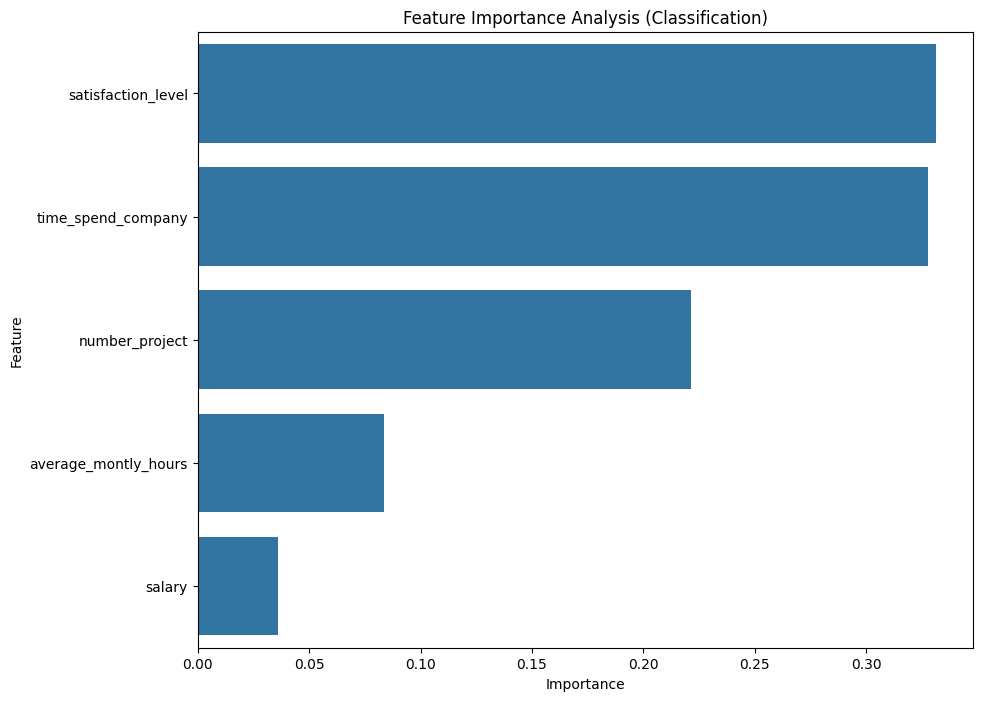

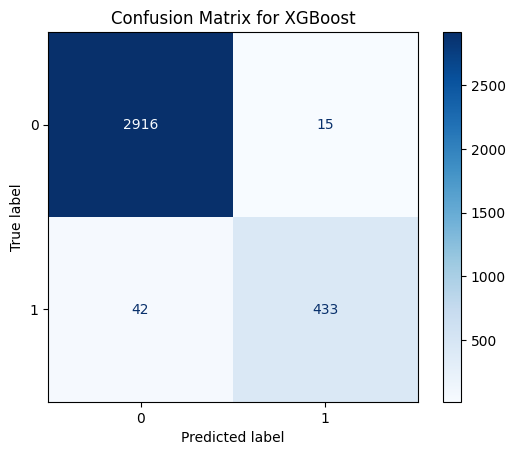

Accuracy: 0.983
Precision: 0.967
Recall: 0.912
F1 Score: 0.938
ROC AUC: 0.982


In [24]:
# Find best classification model
best_class_model_name, best_class_model, best_class_sampler, best_class_params, class_model_times = find_best_hyperparameters_classification(
    preprocessor_class.transform(X_class_train),
    y_class_train,
    preprocessor_class.transform(X_class_test),
    y_class_test
)

# Extract feature names from the preprocessing pipeline for classification
all_feature_names_class = numerical_cols + ordinal_cols

# Ensure resampled data remains a DataFrame
X_resampled, y_resampled = resampled_datasets[best_class_sampler]
X_resampled_df = pd.DataFrame(X_resampled, columns=all_feature_names_class)

# Fit the best model
best_class_model.fit(X_resampled_df, y_resampled)

# Extract feature importance
feature_importances_class = best_class_model.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
importance_df_class = pd.DataFrame({'Feature': all_feature_names_class, 'Importance': feature_importances_class})
importance_df_class = importance_df_class.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_class)
plt.title('Feature Importance Analysis (Classification)')
plt.show()

importance_df_class.head(10)

# Confusion matrix and classification report for the best classification model
X_class_test_transformed = preprocessor_class.transform(X_class_test)
y_pred = best_class_model.predict(X_class_test_transformed)
cm = confusion_matrix(y_class_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {best_class_model_name}')
plt.show()

# Calculate classification metrics
accuracy = accuracy_score(y_class_test, y_pred)
precision = precision_score(y_class_test, y_pred)
recall = recall_score(y_class_test, y_pred)
f1 = f1_score(y_class_test, y_pred)
roc_auc = roc_auc_score(y_class_test, best_class_model.predict_proba(X_class_test_transformed)[:, 1])

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

### Evaluating models for Random OverSampler dataset ###
Logistic Regression: ROC AUC Score = 0.845, Training Time: 0.264 seconds, Best Params: {'model__C': 0.1}
Random Forest: ROC AUC Score = 0.982, Training Time: 12.041 seconds, Best Params: {'model__max_depth': 15, 'model__n_estimators': 150}
XGBoost: ROC AUC Score = 0.980, Training Time: 1.499 seconds, Best Params: {'model__max_depth': 7, 'model__n_estimators': 100}
Gradient Boosting: ROC AUC Score = 0.981, Training Time: 8.713 seconds, Best Params: {'model__max_depth': 5, 'model__n_estimators': 100}
K-Nearest Neighbors: ROC AUC Score = 0.948, Training Time: 0.429 seconds, Best Params: {'model__n_neighbors': 7}
--------------------------------------------------
### Evaluating models for SMOTE dataset ###
Logistic Regression: ROC AUC Score = 0.844, Training Time: 0.213 seconds, Best Params: {'model__C': 0.1}
Random Forest: ROC AUC Score = 0.979, Training Time: 15.980 seconds, Best Params: {'model__max_depth': 15, 'model__n_estimator

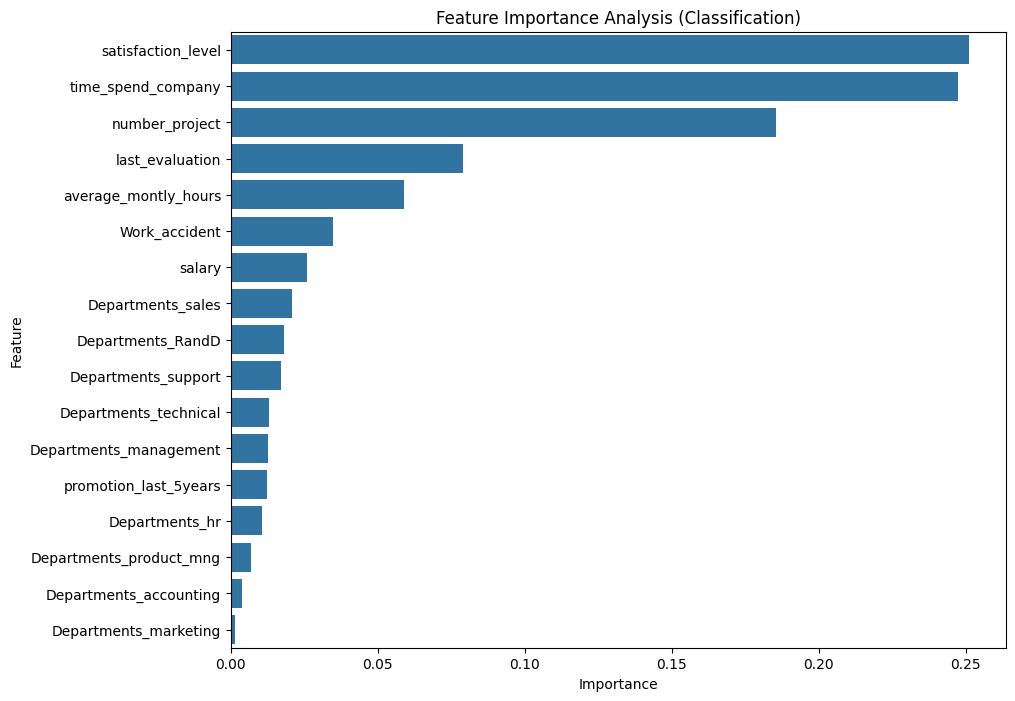

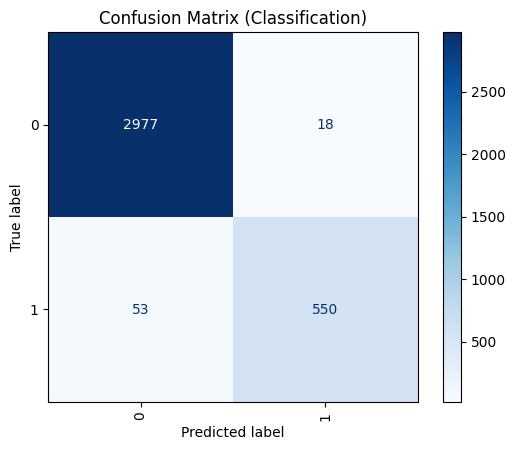

Accuracy: 0.980
Precision: 0.968
Recall: 0.912
F1 Score: 0.939
ROC AUC Score: 0.979


In [ ]:
# Find best classification model
best_class_model_info = find_best_hyperparameters_classification(
    preprocessor_class.transform(X_class_train),
    y_class_train,
    preprocessor_class.transform(X_class_test),
    y_class_test
)

# Extract feature names from the preprocessing pipeline for classification
feature_names_num = numerical_cols.tolist()
feature_names_ord = ordinal_cols
feature_names_nom = preprocessor_class.named_transformers_['nom'].get_feature_names_out(nominal_cols)

all_feature_names = np.concatenate([feature_names_num, feature_names_ord, feature_names_nom])

# Ensure resampled data remains a DataFrame
X_resampled, y_resampled = resampled_datasets[best_class_model_info['sampler']]
X_resampled_df = pd.DataFrame(X_resampled, columns=all_feature_names)

# Fit the best model
best_class_model = best_class_model_info['model']
if isinstance(best_class_model, str):
    best_class_model = classification_models[best_class_model]
best_class_model = best_class_model.fit(X_resampled_df, y_resampled)

# Perform cross-validation for classification model
print('\nCross-Validation Results (Classification Model)')
cross_val_classification(best_class_model, X_resampled_df, y_resampled)

# Check if the model has 'feature_importances_'
if hasattr(best_class_model, 'feature_importances_'):
    # Extract feature importance
    feature_importances = best_class_model.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance Analysis (Classification)')
    plt.show()

    importance_df.head(10)
else:
    print('No feature importances available for this model.')

# Confusion matrix
y_pred_class = best_class_model.predict(preprocessor_class.transform(X_class_test))
cm = confusion_matrix(y_class_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_class_model.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix (Classification)')
plt.show()

# Evaluation metrics
accuracy = accuracy_score(y_class_test, y_pred_class)
precision = precision_score(y_class_test, y_pred_class)
recall = recall_score(y_class_test, y_pred_class)
f1 = f1_score(y_class_test, y_pred_class)
roc_auc = roc_auc_score(y_class_test, best_class_model.predict_proba(preprocessor_class.transform(X_class_test))[:, 1])

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'ROC AUC Score: {roc_auc:.3f}')

Linear Regression: R2 = 0.040, Training Time: 0.011 seconds, Best Params: {}
Decision Tree: R2 = 0.292, Training Time: 0.059 seconds, Best Params: {'model__max_depth': 5}
Random Forest: R2 = 0.300, Training Time: 10.549 seconds, Best Params: {'model__max_depth': 5, 'model__n_estimators': 150}
XGBoost: R2 = 0.306, Training Time: 0.896 seconds, Best Params: {'model__max_depth': 3, 'model__n_estimators': 50}
Gradient Boosting: R2 = 0.307, Training Time: 2.127 seconds, Best Params: {'model__max_depth': 3, 'model__n_estimators': 100}
K-Nearest Neighbors: R2 = 0.215, Training Time: 0.127 seconds, Best Params: {'model__n_neighbors': 7}
Best Regression Model: XGBoost (R2 Score = 0.306)
Selected Hyperparameters: {'model__max_depth': 3, 'model__n_estimators': 50}
Training Times: {'Linear Regression': 0.010825634002685547, 'Decision Tree': 0.05931448936462402, 'Random Forest': 10.54909610748291, 'XGBoost': 0.8960342407226562, 'Gradient Boosting': 2.1270856857299805, 'K-Nearest Neighbors': 0.12656

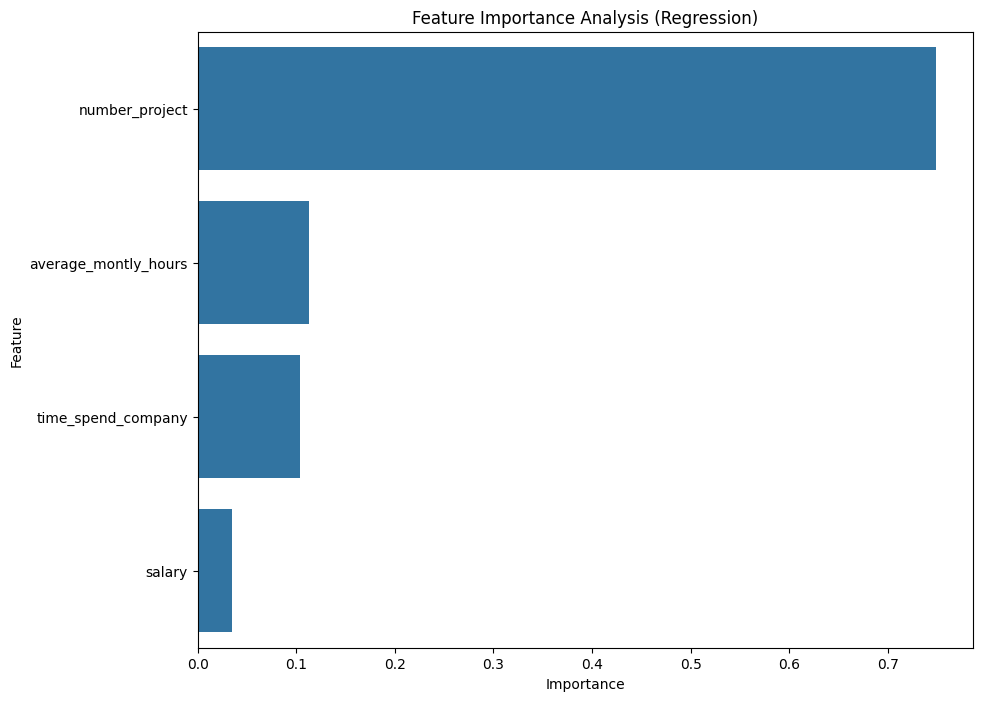

,Feature,Importance
2,number_project,0.748696
1,average_montly_hours,0.113045
0,time_spend_company,0.103920
3,salary,0.034339


In [25]:
# Find best regression model
best_reg_model_name, best_reg_model, best_reg_params, reg_model_times = find_best_hyperparameters_regression(
    preprocessor_reg.fit_transform(X_reg_train),
    y_reg_train,
    preprocessor_reg.transform(X_reg_test),
    y_reg_test
)

# Extract feature names from the preprocessing pipeline for regression
feature_names_num_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_names_ord = ordinal_cols
all_feature_names_reg = feature_names_num_reg + feature_names_ord

all_feature_names_reg = np.concatenate([feature_names_num_reg, feature_names_ord])

# Fit the best model
best_reg_model.fit(preprocessor_reg.fit_transform(X_reg_train), y_reg_train)

# # Perform cross-validation for regression model
# print('\nCross-Validation Results (Regression Model)')
# cross_val_regression(best_reg_model, preprocessor_reg.transform(X_reg_train), y_reg_train)

# Extract feature importance
feature_importances_reg = best_reg_model.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
importance_df_reg = pd.DataFrame({'Feature': all_feature_names_reg, 'Importance': feature_importances_reg})
importance_df_reg = importance_df_reg.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_reg)
plt.title('Feature Importance Analysis (Regression)')
plt.show()

importance_df_reg.head(10)